**ISCTE - Lisbon University Institute**

Master Degree in Artificial Intelligence
Advanced Machine Learning
2025/2026 - 1st semester

*Project Assignement*
Version 1.0 (2025-11-18)

    This work must be carried individually or in pairs of 2 students (recommended).
    Deadline: Saturday, December 6, until 11:59 PM.
    The project presentation will take place on December 9, during class time.

*Part 1 – POS Tagging*
The goal of this assignment is to develop and compare models for Part-of-Speech (POS) tagging using two different deep learning architectures:

    *LSTM-based models*
    *Pre-trained transformer-based models*

Students will train or fine-tune, evaluate, and analyze the performance of these models on the provided dataset.

**Dataset**

For this part we will be using the Universal Dependencies English Web Treebank data (v2.17 - 2025-11-15). The data is already split into training, development and test subsets.

en_ewt-ud-train.conllu
en_ewt-ud-dev.conllu
en_ewt-ud-test.conllu

Each one of these subsets contain words, grouped by sentences, each one of them labeled with the corresponding POS tag. After downloading the data, the following function can be used to load each one of the datasets individually.

In [15]:
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, accuracy_score

**Task 1.1 - Train an LSTM-Based Model**

    Train a sequence model (e.g. LSTM) on the training set.
    Include an embedding layer. Pre-trained embeddings, such as Glove embeddings, are avaliable for download and can be used.
    Output a POS tag per token using a softmax classifier.

Evaluate your model on the test set

    Report the global performance using Accuracy
    Report the performance per-class using Precision, Recall, F1-score
    
Report training time, model size, and any hardware constraints.

In [16]:
# --- Funções de Leitura de Dados ---

def read_conllu_file(filepath):
    """
    Read a CoNLL-U format file and extract words and POS tags sentence by sentence.
    
    Args:
        filepath: Path to the CoNLL-U file
        
    Returns:
        A list of dictionaries, each containing 'words' and 'pos_tags' lists for a sentence
    """
    sentences = []
    current_sentence = {'words': [], 'pos_tags': []}
    
    with open(filepath, "r", encoding="utf-8") as data_file:
        for line in data_file:
            if line.startswith("#"):
                # Skip comment lines
                pass
            elif line.strip() == "":
                # Empty line marks end of sentence
                if current_sentence['words']:  # Only add non-empty sentences
                    sentences.append(current_sentence)
                    current_sentence = {'words': [], 'pos_tags': []}
            else:
                # Parse the token line
                fields = line.split("\t")
                word, pos = fields[1], fields[3]
                current_sentence['words'].append(word)
                current_sentence['pos_tags'].append(pos)
    
    return sentences

#load data
TRAIN = "./data/en_ewt-ud-train.conllu"
DEV = "./data/en_ewt-ud-dev.conllu"
TEST = "./data/en_ewt-ud-test.conllu"

# --- 1) Carregar Dados ---
try:
    train_sents = read_conllu_file(TRAIN)
    dev_sents = read_conllu_file(DEV)
    test_sents = read_conllu_file(TEST)
    print("Loaded sentences:", len(train_sents), len(dev_sents), len(test_sents))
except FileNotFoundError as e:
    print(f"Erro: Ficheiro de dados não encontrado: {e.filename}. Certifique-se de que os ficheiros CoNLL-U estão em './data/'")
    exit()

# Display preview
print(f"Total sentences: {len(dev_sents)}")
print(f"First 3 sentences:")
for i, sent in enumerate(dev_sents[:3]):
    print(f"Sentence {i+1}:")
    print(f"  Words: {sent['words']}")
    print(f"  POS tags: {sent['pos_tags']}")

Loaded sentences: 12544 2001 2077
Total sentences: 2001
First 3 sentences:
Sentence 1:
  Words: ['From', 'the', 'AP', 'comes', 'this', 'story', ':']
  POS tags: ['ADP', 'DET', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT']
Sentence 2:
  Words: ['President', 'Bush', 'on', 'Tuesday', 'nominated', 'two', 'individuals', 'to', 'replace', 'retiring', 'jurists', 'on', 'federal', 'courts', 'in', 'the', 'Washington', 'area', '.']
  POS tags: ['PROPN', 'PROPN', 'ADP', 'PROPN', 'VERB', 'NUM', 'NOUN', 'PART', 'VERB', 'VERB', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'PROPN', 'NOUN', 'PUNCT']
Sentence 3:
  Words: ['Bush', 'nominated', 'Jennifer', 'M.', 'Anderson', 'for', 'a', '15', '-', 'year', 'term', 'as', 'associate', 'judge', 'of', 'the', 'Superior', 'Court', 'of', 'the', 'District', 'of', 'Columbia', ',', 'replacing', 'Steffen', 'W.', 'Graae', '.']
  POS tags: ['PROPN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'ADP', 'DET', 'NUM', 'PUNCT', 'NOUN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'PROP

In [17]:
# --- Funções de Loss e Métrica Personalizadas para Ignorar Padding ---

# O valor que usamos para padding nos labels.
# Deve ser um valor negativo ou um valor que não seja um índice de classe válido.
PAD_VALUE = -100

def masked_sparse_categorical_crossentropy(y_true, y_pred):
    """
    Calcula a sparse_categorical_crossentropy ignorando os tokens de padding.
    O padding é identificado pelo valor PAD_VALUE nos labels y_true.
    """
    # 1. Criar a máscara: 1.0 onde o label não é PAD_VALUE, 0.0 onde é.
    # y_true tem shape (batch_size, max_len).
    mask = tf.cast(tf.not_equal(y_true, PAD_VALUE), tf.float32)
    
    # 2. Converter y_true para um tensor de inteiros (necessário para a loss).
    # O Keras exige que os labels sejam >= 0. Vamos substituir PAD_VALUE por 0
    # APENAS para o cálculo da loss, mas a máscara garante que o seu contributo é zero.
    y_true_safe = tf.where(tf.equal(y_true, PAD_VALUE), tf.constant(0, dtype=y_true.dtype), y_true)
    
    # 3. Calcular a loss normal (por token).
    # sparse_categorical_crossentropy espera y_true com shape (batch_size, max_len)
    # e y_pred com shape (batch_size, max_len, num_classes).
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_safe, y_pred)
    
    # 4. Aplicar a máscara à loss.
    masked_loss = loss * mask
    
    # 5. Normalizar a loss pelo número de tokens não-padding.
    # Isto é crucial para que a loss não diminua artificialmente com o aumento do padding.
    num_non_padded_tokens = tf.reduce_sum(mask)
    
    # Evitar divisão por zero
    return tf.reduce_sum(masked_loss) / (num_non_padded_tokens + 1e-7)

def masked_accuracy(y_true, y_pred):
    """
    Calcula a acurácia ignorando os tokens de padding.
    """
    # 1. Criar a máscara.
    mask = tf.cast(tf.not_equal(y_true, PAD_VALUE), tf.float32)
    
    # 2. Obter as classes previstas (índice da maior probabilidade).
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)
    
    # 3. Converter y_true para um tensor de inteiros (para comparação).
    y_true_int = tf.cast(y_true, tf.int32)
    
    # 4. Comparar previsões com labels verdadeiros.
    matches = tf.cast(tf.equal(y_true_int, y_pred_class), tf.float32)
    
    # 5. Aplicar a máscara.
    masked_matches = matches * mask
    
    # 6. Normalizar a acurácia pelo número de tokens não-padding.
    num_non_padded_tokens = tf.reduce_sum(mask)
    
    # Evitar divisão por zero
    return tf.reduce_sum(masked_matches) / (num_non_padded_tokens + 1e-7)

In [22]:
from collections import Counter

DIM = 300

# --- Configuração de Parâmetros ---
glove_path = f"../data/glove.2024.wikigiga.${DIM}d/wiki_giga_2024_${DIM}_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt" # ajusta se necessário

EMB_DIM = DIM
MAX_LEN = DIM
BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 1e-3
PAD_INDEX = 0 # Índice para o token <PAD> no word2idx


# --- 2) Vocab / encoding / padding ---
word_counts = Counter(w for s in train_sents for w in s['words'])
word2idx = {"<PAD>":PAD_INDEX, "<UNK>":1}
for w,_ in word_counts.items():
    if w not in word2idx:
        word2idx[w] = len(word2idx)

tags = sorted(list({t for s in train_sents for t in s['pos_tags']}))
tag2idx = {t:i for i,t in enumerate(tags)}
idx2tag = {i:t for t,i in tag2idx.items()}
num_tags = len(tag2idx)
vocab_size = len(word2idx)
print("Vocab size:", vocab_size, "num tags:", num_tags)

def encode_sentences(sents, w2i, t2i):
    X, y = [], []
    for s in sents:
        X.append([w2i.get(w, w2i["<UNK>"]) for w in s['words']])
        y.append([t2i[t] for t in s['pos_tags']])
    return X, y

X_train, y_train = encode_sentences(train_sents, word2idx, tag2idx)
X_dev, y_dev = encode_sentences(dev_sents, word2idx, tag2idx)
X_test, y_test = encode_sentences(test_sents, word2idx, tag2idx)

# Padding dos inputs (X)
X_train_p = pad_sequences(X_train, maxlen=MAX_LEN, padding='post', truncating='post')
X_dev_p = pad_sequences(X_dev, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_p = pad_sequences(X_test, maxlen=MAX_LEN, padding='post', truncating='post')

# Padding dos labels (y) com o valor especial PAD_VALUE
y_train_p = pad_sequences(y_train, maxlen=MAX_LEN, padding='post', truncating='post', value=PAD_VALUE)
y_dev_p = pad_sequences(y_dev, maxlen=MAX_LEN, padding='post', truncating='post', value=PAD_VALUE)
y_test_p = pad_sequences(y_test, maxlen=MAX_LEN, padding='post', truncating='post', value=PAD_VALUE)

# Garante que os labels são int32 (necessário para Keras)
y_train_sparse = y_train_p.astype(np.int32)
y_dev_sparse = y_dev_p.astype(np.int32)
y_test_sparse = y_test_p.astype(np.int32)

# --- 3) Carregar GloVe e montar embedding_matrix ---
rng = np.random.RandomState(12345)
embedding_matrix = rng.normal(scale=0.6, size=(vocab_size, EMB_DIM)).astype(np.float32)
embedding_matrix[PAD_INDEX] = np.zeros((EMB_DIM,), dtype=np.float32)

if os.path.exists(glove_path):
    wanted = set(word2idx.keys()) | set(w.lower() for w in word2idx.keys())
    found = 0
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            if word not in wanted:
                continue
            vec = np.asarray(parts[1:], dtype=np.float32)
            if vec.shape[0] != EMB_DIM:
                continue

            # Coloca em qualquer índice correspondente (case-sensitive then lowercase)
            if word in word2idx:
                embedding_matrix[word2idx[word]] = vec
                found += 1
            lower = word.lower()
            if lower in word2idx and word2idx[lower] != word2idx.get(word): # Evitar contar duas vezes se word == lower
                embedding_matrix[word2idx[lower]] = vec
                found += 1
    print(f"GloVe: found {found} tokens from vocab and loaded into embedding_matrix")
else:
    print("Warning: GloVe file not found at", glove_path, "-> using random init")

embedding_matrix[PAD_INDEX] = np.zeros((EMB_DIM,), dtype=np.float32) # Re-assert PAD row is zero

# --- 4) Construir o modelo Keras com Embedding congelada ---
inp = Input(shape=(MAX_LEN,), dtype='int32', name="input_ids")
emb = Embedding(input_dim=vocab_size,
                output_dim=EMB_DIM,
                weights=[embedding_matrix],
                input_length=MAX_LEN,
                mask_zero=True, # Importante para o Keras ignorar o padding no LSTM
                trainable=False,
                )(inp)

x = Bidirectional(LSTM(128, return_sequences=True), name="bilstm")(emb)
out = TimeDistributed(Dense(num_tags, activation='softmax'), name="tag_out")(x)

model = Model(inputs=inp, outputs=out)
optimizer = Adam(learning_rate=LEARNING_RATE)

# --- COMPILAÇÃO COM LOSS E MÉTRICA PERSONALIZADAS ---
model.compile(optimizer=optimizer,
              loss=masked_sparse_categorical_crossentropy,
              metrics=[masked_accuracy])

model.summary()

# --- 5) Treinar ---
print("\n--- INÍCIO DO TREINO (Com Loss e Métrica Corrigidas) ---")
start = time.time()
history = model.fit(X_train_p, y_train_sparse,
                    validation_data=(X_dev_p, y_dev_sparse),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE
                    )
train_time = time.time() - start
print(f"\nTreino concluído em {train_time:.1f} s")

# --- 6) Avaliar no test set: obter previsões token-level e métricas por classe ---
preds = model.predict(X_test_p, batch_size=BATCH_SIZE, verbose=0) # shape (N, MAX_LEN, num_tags)
pred_labels = np.argmax(preds, axis=-1) # Flatten ignorando os PAD_VALUE tokens

def flatten_preds_trues(preds_labels, true_padded, mask_value=PAD_VALUE):
    """ Função original do utilizador para avaliação final, mantida. """
    pred_flat = []
    true_flat = []
    for p_seq, t_seq in zip(preds_labels, true_padded):
        for p, t in zip(p_seq, t_seq):
            if t == mask_value:
                continue
            pred_flat.append(int(p))
            true_flat.append(int(t))
    return pred_flat, true_flat

pred_flat, true_flat = flatten_preds_trues(pred_labels, y_test_p, mask_value=PAD_VALUE)
acc = accuracy_score(true_flat, pred_flat)
print(f"\nTest Accuracy (token-level - avaliação final): {acc:.4f}\n")

# O classification_report requer que os labels sejam 0-indexed, o que é o caso
# porque o tag2idx começa em 0.
print("Classification report (Precision/Recall/F1):\n")
print(classification_report(true_flat, pred_flat, target_names=[idx2tag[i] for i in range(num_tags)], zero_division=0))

# --- 7) Guardar modelo / embedding_matrix se quiseres ---
model.save("pos_model_glove_frozen_corrected.h5")
np.save(f"embedding_matrix_${MAX_LEN}d.npy", embedding_matrix)
print("Model e embedding matrix salvos.")

Vocab size: 20203 num tags: 18


c:\Users\jcosta\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 300, 300)  │  6,060,900 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 300)       │          0 │ input_ids[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 300, 256)  │    439,296 │ embedding_3[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tag_out             │ (None, 300, 18)   │      4,626 │ bilstm[0][0],     │
│ (TimeDistributed)   │                   │            │ not_equal_3[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,504,822 (24.81 MB)

 Trainable params: 443,922 (1.69 MB)

 Non-trainable params: 6,060,900 (23.12 MB)


--- INÍCIO DO TREINO (Com Loss e Métrica Corrigidas) ---
Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - loss: 1.3073 - masked_accuracy: 0.6212 - val_loss: 0.7996 - val_masked_accuracy: 0.7566
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - loss: 0.6278 - masked_accuracy: 0.8052 - val_loss: 0.6155 - val_masked_accuracy: 0.8117
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 405s 4s/step - loss: 0.4760 - masked_accuracy: 0.8533 - val_loss: 0.5180 - val_masked_accuracy: 0.8426
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 446s 5s/step - loss: 0.3791 - masked_accuracy: 0.8849 - val_loss: 0.4576 - val_masked_accuracy: 0.8593
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 419s 4s/step - loss: 0.3063 - masked_accuracy: 0.9092 - val_loss: 0.4218 - val_masked_accuracy: 0.8710

Treino concluído em 2137.1 s



Test Accuracy (token-level - avaliação final): 0.8686

Classification report (Precision/Recall/F1):

              precision    recall  f1-score   support

         ADJ       0.86      0.67      0.75      1788
         ADP       0.92      0.95      0.94      2025
         ADV       0.91      0.78      0.84      1191
         AUX       0.96      0.97      0.96      1543
       CCONJ       0.99      0.99      0.99       736
         DET       0.98      0.98      0.98      1897
        INTJ       0.97      0.57      0.72       121
        NOUN       0.74      0.86      0.80      4123
         NUM       0.90      0.44      0.60       542
        PART       0.93      0.94      0.94       649
        PRON       0.98      0.96      0.97      2165
       PROPN       0.61      0.70      0.65      2075
       PUNCT       0.98      0.99      0.98      3096
       SCONJ       0.85      0.74      0.79       384
         SYM       0.82      0.60      0.69       113
        VERB       0.87      0.85

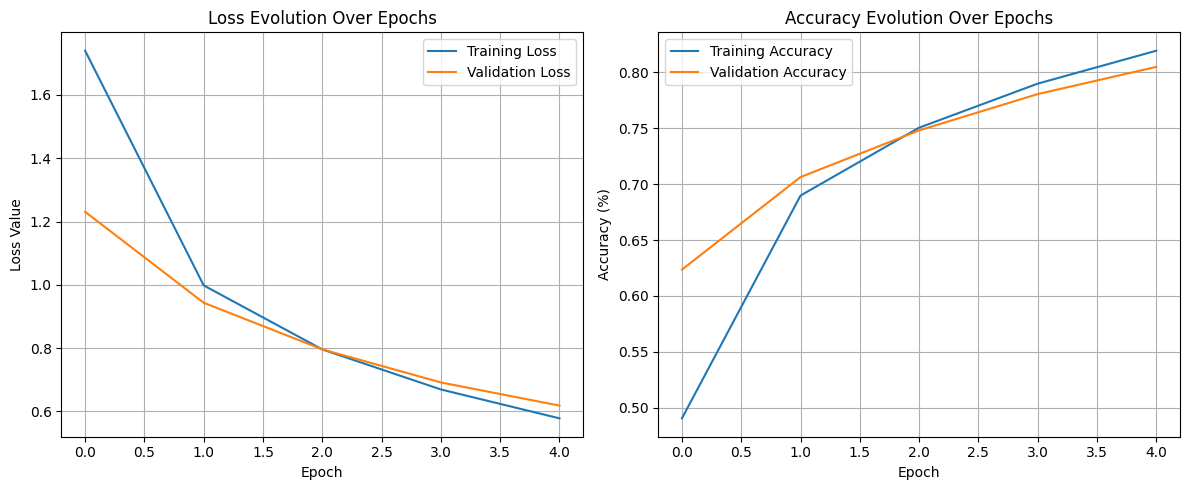

In [ ]:
#DIM 100

import matplotlib.pyplot as plt

history

## --- 1. Plot Training & Validation Loss ---
plt.figure(figsize=(12, 5))

# Subplot for Loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution Over Epochs')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

## --- 2. Plot Training & Validation Accuracy ---

# Subplot for Accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
# NOTE: Use the exact name of your custom metric defined in model.compile()
train_metric = 'masked_accuracy'
val_metric = 'val_masked_accuracy'

plt.plot(history.history[train_metric], label='Training Accuracy')
plt.plot(history.history[val_metric], label='Validation Accuracy')
plt.title('Accuracy Evolution Over Epochs')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjusts subplots to fit in figure area
plt.show()

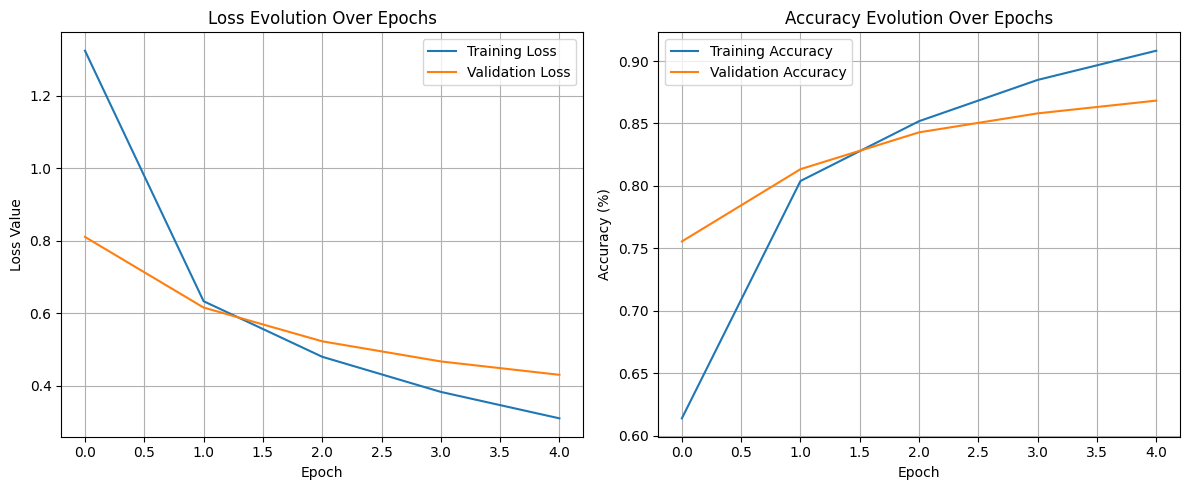

In [ ]:
#DIM 300

import matplotlib.pyplot as plt

history

## --- 1. Plot Training & Validation Loss ---
plt.figure(figsize=(12, 5))

# Subplot for Loss
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution Over Epochs')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

## --- 2. Plot Training & Validation Accuracy ---

# Subplot for Accuracy
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
# NOTE: Use the exact name of your custom metric defined in model.compile()
train_metric = 'masked_accuracy'
val_metric = 'val_masked_accuracy'

plt.plot(history.history[train_metric], label='Training Accuracy')
plt.plot(history.history[val_metric], label='Validation Accuracy')
plt.title('Accuracy Evolution Over Epochs')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjusts subplots to fit in figure area
plt.show()

**Task 1.2 - Transformer-Based Encoder Model**

    Choose an encoder-based model (e.g., DistilBERT, BERT, RoBERTa, NeoBERT, EuroBERT)
    Ensure proper handling of subword tokenization (alignment between tokens and tags).
    Fine-tune the model for token-level classification (POS tagging).

Evaluate your model on the test set. Please take into account that the tokens being used by the model may not entirely correspond to existing the tokens

    Report the global performance using Accuracy
    Report the performance per-class using Precision, Recall, F1-score

Report training time, model size, and any hardware constraints.

In [ ]:
# Task 1.2 - Transformer Token-level POS tagging (BERT-style)
# Requirements:
# pip install transformers datasets conllu sklearn torch tqdm

import os
import time
import json
from collections import defaultdict, Counter
from typing import List, Tuple

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)
from sklearn.metrics import classification_report, accuracy_score
from tqdm.auto import tqdm

# -------------------------
# Config
# -------------------------
MODEL_NAME = "distilbert-base-uncased"  # change to bert-base-cased / roberta-base as desired
TRAIN_PATH = "./data/en_ewt-ud-train.conllu"
DEV_PATH = "./data/en_ewt-ud-dev.conllu"
TEST_PATH = "./data/en_ewt-ud-test.conllu"
OUTPUT_DIR = "./transformer_pos_output"
BATCH_SIZE = 16
EPOCHS = 3
LR = 5e-5
MAX_LEN = 128
SEED = 42

# -------------------------
# Utilities: parse simple CoNLL-U (extract tokens + UPOS)
# -------------------------
def read_conllu(path: str) -> List[dict]:
    """Return list of sentences: {'words': [...], 'pos': [...]}"""
    sentences = []
    with open(path, "r", encoding="utf-8") as f:
        words, pos = [], []
        for line in f:
            line = line.strip()
            if line == "":
                if words:
                    sentences.append({"words": words, "pos": pos})
                    words, pos = [], []
                continue
            if line.startswith("#"):
                continue
            parts = line.split("\t")
            if len(parts) < 4:
                continue
            idx = parts[0]
            if "-" in idx:  # skip multiword token lines
                continue
            token = parts[1]
            upos = parts[3]  # UPOS (universal POS)
            words.append(token)
            pos.append(upos)
        # final
        if words:
            sentences.append({"words": words, "pos": pos})
    return sentences

# -------------------------
# Build label map
# -------------------------
def build_label_map(*datasets):
    labels = set()
    for ds in datasets:
        for s in ds:
            labels.update(s["pos"])
    label_list = sorted(labels)
    label_to_id = {lbl: i for i, lbl in enumerate(label_list)}
    id_to_label = {i: lbl for lbl, i in label_to_id.items()}
    return label_list, label_to_id, id_to_label

# -------------------------
# Tokenize & align labels for subword tokenization
# -------------------------
def tokenize_and_align_labels(sentences, tokenizer, label_to_id, max_length=128):
    """
    sentences: list of {'words': [...], 'pos': [...]}
    returns dict with input_ids, attention_mask, labels (aligned and using -100 for subword pieces)
    """
    encodings_inputs = []
    labels_aligned = []

    for s in tqdm(sentences, desc="Tokenizing & aligning"):
        words = s["words"]
        pos_tags = s["pos"]
        # tokenizer with is_split_into_words: it treats each item as a word
        encoding = tokenizer(
            words,
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_attention_mask=True,
        )
        word_ids = encoding.word_ids()  # maps token index -> word index or None
        label_ids = []
        for wid in word_ids:
            if wid is None:
                label_ids.append(-100)
            else:
                # Only label the first token of a word (or you could label all subtokens)
                # strategy: label first subtoken, set subsequent subtoken labels to -100
                # detect first subtoken:
                # We detect first subtoken by checking whether the previous token's word id is same or not
                label_ids.append(label_to_id[pos_tags[wid]])
        # Now convert non-first subtoken labels to -100:
        # find token indices and their word_ids
        prev_wid = None
        final_label_ids = []
        for token_idx, wid in enumerate(word_ids):
            if wid is None:
                final_label_ids.append(-100)
                prev_wid = None
            else:
                if wid != prev_wid:
                    # first subtoken of a word -> keep label id
                    final_label_ids.append(label_to_id[pos_tags[wid]])
                else:
                    # subsequent subtoken -> ignore in loss
                    final_label_ids.append(-100)
                prev_wid = wid

        encodings_inputs.append({
            "input_ids": encoding["input_ids"],
            "attention_mask": encoding["attention_mask"]
        })
        labels_aligned.append(final_label_ids)

    # Build flat dict arrays
    input_ids = [e["input_ids"] for e in encodings_inputs]
    attention_mask = [e["attention_mask"] for e in encodings_inputs]
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels_aligned}

# -------------------------
# Small Dataset class for Trainer
# -------------------------
class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings["input_ids"])
    def __getitem__(self, idx):
        item = {k: torch.tensor(self.encodings[k][idx]) for k in self.encodings}
        return item

# -------------------------
# Load data
# -------------------------
train_sents = read_conllu(TRAIN_PATH)
dev_sents = read_conllu(DEV_PATH)
test_sents = read_conllu(TEST_PATH)

label_list, label_to_id, id_to_label = build_label_map(train_sents, dev_sents, test_sents)
num_labels = len(label_list)
print("Labels ({}): {}".format(num_labels, label_list))

# -------------------------
# Tokenizer + Model
# -------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

# Ensure consistent random
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# -------------------------
# Tokenize & align
# -------------------------
train_enc = tokenize_and_align_labels(train_sents, tokenizer, label_to_id, max_length=MAX_LEN)
dev_enc = tokenize_and_align_labels(dev_sents, tokenizer, label_to_id, max_length=MAX_LEN)
test_enc = tokenize_and_align_labels(test_sents, tokenizer, label_to_id, max_length=MAX_LEN)

train_dataset = TokenDataset(train_enc)
dev_dataset = TokenDataset(dev_enc)
test_dataset = TokenDataset(test_enc)

# -------------------------
# Data collator
# -------------------------
data_collator = DataCollatorForTokenClassification(tokenizer)

# -------------------------
# Metrics: we will compute predictions then map back to token-level ignoring -100
# -------------------------
def compute_metrics_for_trainer(pred):
    # pred: (logits, labels)
    logits, labels = pred
    preds = logits.argmax(-1)
    # flatten but ignore -100 positions
    true_labels = []
    true_preds = []
    for lp, pp in zip(labels, preds):
        for l, p in zip(lp, pp):
            if l == -100:
                continue
            true_labels.append(id_to_label[int(l)])
            true_preds.append(id_to_label[int(p)])
    acc = accuracy_score(true_labels, true_preds)
    # classification_report from sklearn
    rep = classification_report(true_labels, true_preds, zero_division=0, output_dict=True)
    # we will return aggregated metrics and attach the full report
    # pick macro f1 as a quick scalar
    macro_f1 = rep.get("macro avg", {}).get("f1-score", 0.0)
    return {"accuracy": acc, "macro_f1": macro_f1, "classification_report": rep}

# -------------------------
# TrainingArguments & Trainer
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    weight_decay=0.01,
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    logging_steps=50,
    seed=SEED,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda p: {"accuracy": compute_metrics_for_trainer(p)["accuracy"],
                               "macro_f1": compute_metrics_for_trainer(p)["macro_f1"]},
)

# -------------------------
# Train (measure time)
# -------------------------
start_time = time.time()
trainer.train()
train_time = time.time() - start_time
print(f"Training time (s): {train_time:.1f}")

# -------------------------
# Save model & tokenizer
# -------------------------
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

# -------------------------
# Model size (params and disk)
# -------------------------
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# disk size of saved model files
def folder_size(path):
    total = 0
    for root, dirs, files in os.walk(path):
        for f in files:
            fp = os.path.join(root, f)
            total += os.path.getsize(fp)
    return total
disk_bytes = folder_size(OUTPUT_DIR)
print("Total params:", total_params)
print("Trainable params:", trainable_params)
print("Saved model size (bytes):", disk_bytes)

# -------------------------
# Evaluate on test set: produce global accuracy and per-class precision/recall/f1
# -------------------------
# Use trainer.predict to get logits
pred_output = trainer.predict(test_dataset)
# compute full classification_report
metrics_with_report = compute_metrics_for_trainer((pred_output.predictions, pred_output.label_ids))
accuracy = metrics_with_report["accuracy"]
report_dict = metrics_with_report["classification_report"]

print("Test accuracy (token-level, ignoring subtokens):", accuracy)
# Print per-class report
print("Per-class Precision/Recall/F1:")
# report_dict contains classes + macro avg etc
for label in sorted(label_list):
    lab_rep = report_dict.get(label, {"precision": 0.0, "recall": 0.0, "f1-score": 0.0, "support": 0})
    print(f"{label:15s}  P: {lab_rep['precision']:.3f}  R: {lab_rep['recall']:.3f}  F1: {lab_rep['f1-score']:.3f}  sup: {int(lab_rep.get('support',0))}")

# Also print macro/micro averages
print("\nAverages:")
for avg in ["micro avg", "macro avg", "weighted avg"]:
    if avg in report_dict:
        d = report_dict[avg]
        print(f"{avg:10s}  P: {d['precision']:.3f}  R: {d['recall']:.3f}  F1: {d['f1-score']:.3f}  sup: {int(d.get('support',0))}")

# Print training time and hardware summary
print("\n------ SUMMARY ------")
print(f"Model: {MODEL_NAME}")
print(f"Train time (s): {train_time:.1f}")
print(f"Device used: {device}")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print(f"Saved model size (MB): {disk_bytes / (1024*1024):.2f}")

# Save classification report to disk
with open(os.path.join(OUTPUT_DIR, "classification_report.json"), "w", encoding="utf-8") as fh:
    json.dump(report_dict, fh, indent=2)
print(f"Saved detailed classification report to {os.path.join(OUTPUT_DIR, 'classification_report.json')}")


Labels (17): ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Tokenizing & aligning: 100%|██████████| 2077/2077 [00:00<00:00, 6563.24it/s]


Device: cpu


ValueError: --load_best_model_at_end requires the save and eval strategy to match, but found
- Evaluation strategy: IntervalStrategy.NO
- Save strategy: SaveStrategy.EPOCH

**Task 1.3 - Use LLMs to perform the task in the test set (optional, only if you have time)**

    Choose an existing LLM of your choice (e.g., ChatGPT)
    Define a prompt and perform the classification.
    Report the performance of the model, and compare it with your previous models.
    
**Comparison and Analysis**

    Compare the performance of the previous models, in terms of:
        Quantitative performance (metrics)
        Qualitative behavior (e.g., errors, generalization)
        Computational efficiency and training stability

    Discuss potential reasons for performance differences.
    Optionally visualize:
        Confusion matrices
        Learning curves